Apparent winner: 4
Apparently eliminated: 
['47', '6', '3', '5', '2', '1']
Built 6 trees.


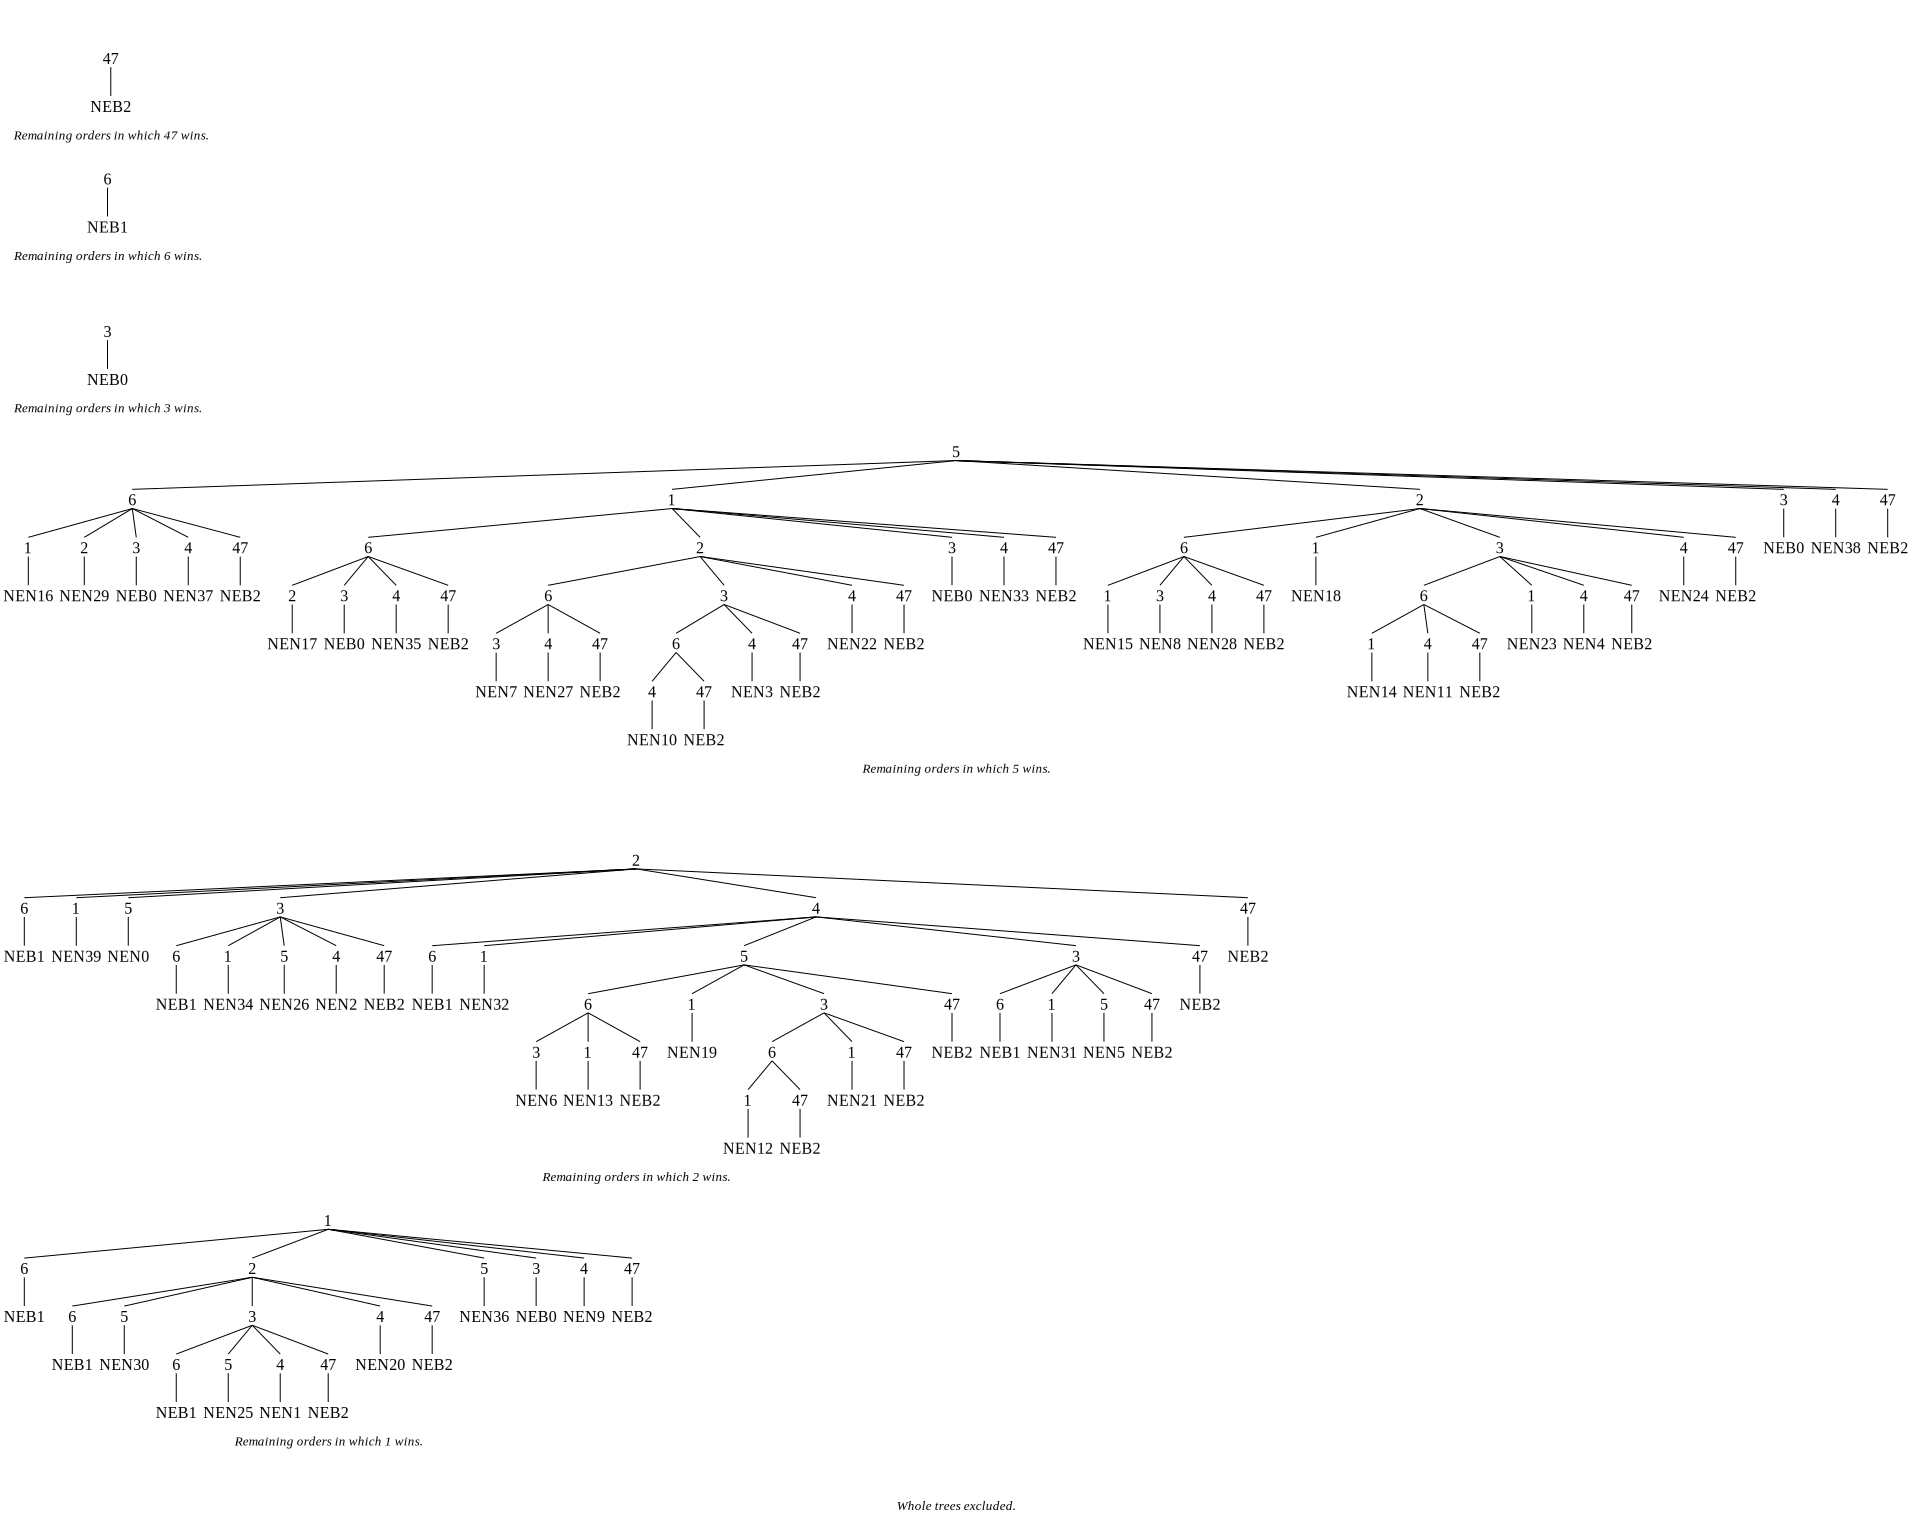

In [1]:
import json
import svgling
from svgling.figure import Caption, SideBySide, RowByRow
from IRVVisualisationUtils import treeListToTuple, parseAssertions, printAssertions, buildRemainingTreeAsLists,
            buildPrintedResults

a_file = open("../AssertionJSON/RAIRE_sample_audit1.json")
auditfile = json.load(a_file)
        
(apparentWinner, apparentNonWinners, WOLosers,IRVElims) = parseAssertions(auditfile)
                
elimTrees = buildPrintedResults(apparentWinner, apparentNonWinners, WOLosers,IRVElims)

print("Built "+str(len(elimTrees))+" trees.")
#print("Warning: hardcoded to print 6 trees!")
Caption(RowByRow(RowByRow(RowByRow(elimTrees[0],elimTrees[1]),RowByRow(elimTrees[2],elimTrees[3])),RowByRow(elimTrees[4],elimTrees[5])   ), "Whole trees excluded.")



# RAIRE example assertions

This notebook provides a simple example of the kinds of assertions RAIRE might derive.
Suppose we have the following IRV CVRs:
- 10 votes list (Alpine, Beach, Canyon)
- 10 votes list (Alpine, Beach, Desert)
- 25 votes list (Beach)
- 6  votes list (Canyon, Alpine, Beach)
- 4  votes list (Desert, Alpine, Beach)
The apparent winner is Alpine, with apparent elimination order Desert, Canyon, Beach, (Alpine), shown below in red.
The audit needs to exclude all the other possible winners, though we don't care about other elimination orders in which Alpine wins.  To see how this works, click in each python box (including the import box above) and press shift-enter, working down the page.

In [2]:
printAssertions(WOLosers,IRVElims)

Not-Eliminated-Before assertions: 
NEB0: Candidate {'2'} cannot be eliminated before 3
NEB1: Candidate {'5'} cannot be eliminated before 6
NEB2: Candidate {'2', '5', '1', '3', '4'} cannot be eliminated before 47
Not-Eliminated-Next assertions: 
NEN0: Candidate 5 cannot be eliminated next when {'6', '1', '3', '4', '47'} are eliminated.
NEN1: Candidate 4 cannot be eliminated next when {'6', '47', '5'} are eliminated.
NEN2: Candidate 4 cannot be eliminated next when {'6', '47', '1', '5'} are eliminated.
NEN3: Candidate 4 cannot be eliminated next when {'6', '47'} are eliminated.
NEN4: Candidate 4 cannot be eliminated next when {'6', '1', '47'} are eliminated.
NEN5: Candidate 5 cannot be eliminated next when {'6', '1', '47'} are eliminated.
NEN6: Candidate 3 cannot be eliminated next when {'1', '47'} are eliminated.
NEN7: Candidate 3 cannot be eliminated next when {'4', '47'} are eliminated.
NEN8: Candidate 3 cannot be eliminated next when {'1', '4', '47'} are eliminated.
NEN9: Candidate 4

From now on we disregard the tree in which Alpine wins, and try to exclude all the others.  First consider Winner-only (WO) comparison between Alpine and Canyon - WO(Canyon,Alpine).  Canyon has only 6 mentions (not counting votes that prefer Alpine).  That's less than Alpine's first preference count of 20.  So Alpine cannot be eliminated before Canyon.

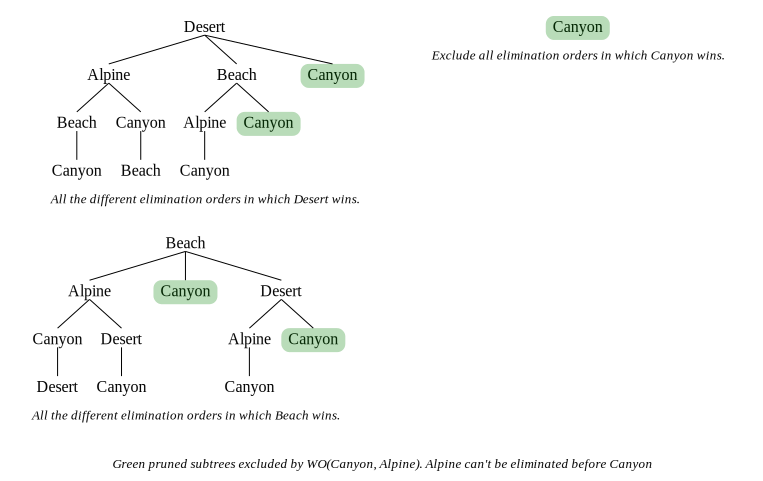

In [7]:
qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),"Canyon",("Desert", ("Alpine", "Canyon"), "Canyon"))
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,1),fill="green")
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert", ("Alpine", ("Beach", "Canyon"), ("Canyon", "Beach")),("Beach", ("Alpine", "Canyon"),"Canyon"),"Canyon")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((2,),fill="green")
out3.box_constituent((1,1),fill="green")
out3 = Caption(out3, "All the different elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Green pruned subtrees excluded by WO(Canyon, Alpine).  Alpine can't be eliminated before Canyon")

Now consider Winner-only (WO) comparison between Alpine and Desert - WO(Desert,Alpine).  Desert has only 4 mentions (not counting votes that prefer Alpine).  That's less than Alpine's first preference count of 20.  So Alpine cannot be eliminated before Desert.

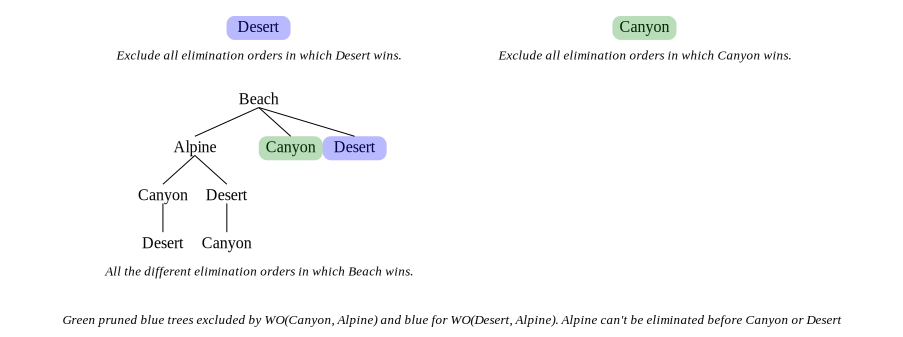

In [8]:
qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),"Canyon","Desert")
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,),fill="blue")
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((),fill="blue")
out3 = Caption(out3, "Exclude all elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Green pruned blue trees excluded by WO(Canyon, Alpine) and blue for WO(Desert, Alpine).  Alpine can't be eliminated before Canyon or Desert")

Finally, WO(Beach,Alpine) doesn't work, because Beach has 25 mentions.  We need to test the last IRV round and compare only Beach, Alpine. This is written as IRV(Beach, Alpine, {Alpine}).

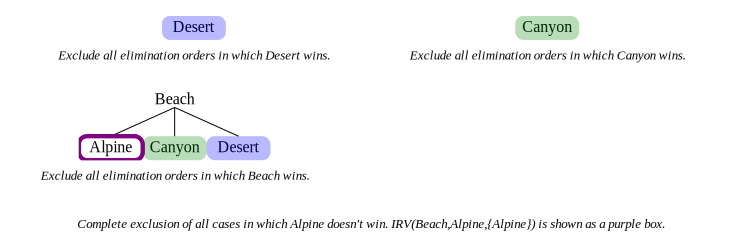

In [10]:
qrtree1 = ("Beach","Alpine","Canyon","Desert")
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((0,),fill="none",stroke_width=4, stroke="purple")
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,),fill="blue")
out1 = Caption(out1, "Exclude all elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((),fill="blue")
out3 = Caption(out3, "Exclude all elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Complete exclusion of all cases in which Alpine doesn't win.  IRV(Beach,Alpine,{Alpine}) is shown as a purple box.")

Now the auditing begins!  We use Risk Limiting Audits to test all three assertions: WO(Canyon,Alpine), WO(Desert,Alpine) and IRV(Beach, Alpine, {Alpine}) simultaneously.